In [1]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

# Import standard libraries
import os, sys
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.pyplot as plt
import copy
import astropy.units as u
import emcee, corner
import seaborn as sns
import pandas as pd

import chimera

import coronagraph as cg
import smart
import smarter; smarter.utils.plot_setup()

/Users/lustija1/opt/anaconda3/lib/python3.8/site-packages/pysynphot/locations.py:345: UserWarning: Extinction files not found in /Users/lustija1/Documents/PandExo_data/pysynphot_data/extinction
  warnings.warn('Extinction files not found in %s' % (extdir, ))
/Users/lustija1/opt/anaconda3/lib/python3.8/site-packages/pysynphot/refs.py:117: UserWarning: No graph or component tables found; functionality will be SEVERELY crippled. No files found for /Users/lustija1/Documents/PandExo_data/pysynphot_data/mtab/*_tmg.fits
  warnings.warn('No graph or component tables found; '
/Users/lustija1/opt/anaconda3/lib/python3.8/site-packages/pysynphot/refs.py:124: UserWarning: No thermal tables found, no thermal calculations can be performed. No files found for /Users/lustija1/Documents/PandExo_data/pysynphot_data/mtab/*_tmt.fits
  warnings.warn('No thermal tables found, '


In [3]:
def extract_flatchain(ep, tag, iburn, mad_cut = None):
    
    # Create useful things
    emcee_backend = str(tag) + "_emcee.h5"
    theta_names = ep.THETA_NAMES
    theta0 = ep.THETA0

    # Create an HDF5 backend
    backend = emcee.backends.HDFBackend(emcee_backend)
   
    if mad_cut is None:
        
        # Use all walkers
        flatchain = backend.get_chain(flat=True, discard = iburn)
        
        # Mask for all walkers
        m = np.array([True for _ in range(backend.shape[0])])
        
    else:
        
        # Index of parameter to apply mad cut
        imad = mad_cut[0]
        
        # Number of mads away from median at which to cut
        nmad = mad_cut[1]
        
        # Cut chains by the MAD 
        chain = backend.get_chain(flat=False, discard = iburn)
        tmp = np.median(chain, axis=0)[:,imad]
        #np.median(tmp), np.median(np.fabs(tmp - np.median(tmp)))
        m = np.fabs(tmp - np.median(tmp)) < nmad*np.median(np.fabs(tmp - np.median(tmp)))
        flatchain = chain[:,m,:].reshape((-1, len(theta_names)))
        
    print("using", m.sum(), "of",  m.size, "walkers")
    
    wl = np.array(ep.wl)
    y_binned = np.array(ep.y_binned)
    y_meas = np.array(ep.y_meas)
    y_err = np.array(ep.y_err)
        
    # Get spectra
    blobs = backend.get_blobs(flat=False, discard = iburn)
    Fobs_post, Fstar_post, Fplan_post = blobs[:,m,0,:].reshape((-1, len(ep.wl))), blobs[:,m,1,:].reshape((-1, len(ep.wl))), blobs[:,m,2,:].reshape((-1, len(ep.wl)))

    return flatchain, dict(wl=wl, y_binned=y_binned, y_meas=y_meas, y_err=y_err, 
                           Fobs_post=Fobs_post, Fstar_post=Fstar_post, Fplan_post=Fplan_post)



In [6]:
#from run_wasp43_mcmc_texp import exopie as exopie_all4; tag = "test_allin4"; iburn=2000
from run_wasp43_free_allin4 import exopie; tag = "test_free_allin4"; iburn=1000
chain, spectra = extract_flatchain(exopie, tag, iburn, mad_cut=None)

using 140 of 140 walkers


In [11]:
spectra.keys()

dict_keys(['wl', 'y_binned', 'y_meas', 'y_err', 'Fobs_post', 'Fstar_post', 'Fplan_post'])

In [9]:
wl = exopie.wl
y_binned = exopie.y_binned
y_meas = exopie.y_meas
y_err = exopie.y_err

In [12]:
# Specify the upper and lower 1- and 3-sigma confidence intervals for the spectra
s1 = 0.6827 # 1-sigma
s2 = 0.9545 # 2-sigma
s3 = 0.9973 # 3-sigma
q1 = [0.5 - 0.5*s1, 0.5, 0.5 + 0.5*s1] # 1-sigma quantiles
q3 = [0.5 - 0.5*s3, 0.5, 0.5 + 0.5*s3] # 3-sigma quantiles

# Calculate percentile spectra (returns: lower bound, median, upper bound)
Fobs_l_1, Fobs_50_1, Fobs_h_1 = np.percentile(spectra['Fobs_post'], list(100.0 * np.array(q1)), axis=0) # 1-sigma
Fobs_l_3, Fobs_50_3, Fobs_h_3 = np.percentile(spectra['Fobs_post'], list(100.0 * np.array(q3)), axis=0) # 3-sigma

Fstar_l_1, Fstar_50_1, Fstar_h_1 = np.percentile(spectra['Fstar_post'], list(100.0 * np.array(q1)), axis=0) # 1-sigma
Fstar_l_3, Fstar_50_3, Fstar_h_3 = np.percentile(spectra['Fstar_post'], list(100.0 * np.array(q3)), axis=0) # 3-sigma

Fplan_l_1, Fplan_50_1, Fplan_h_1 = np.percentile(spectra['Fplan_post'], list(100.0 * np.array(q1)), axis=0) # 1-sigma
Fplan_l_3, Fplan_50_3, Fplan_h_3 = np.percentile(spectra['Fplan_post'], list(100.0 * np.array(q3)), axis=0) # 3-sigma

FpFs_obs_l_1, FpFs_obs_50_1, FpFs_obs_h_1 = np.percentile(y_meas/spectra['Fstar_post']-1.0, list(100.0 * np.array(q1)), axis=0) # 1-sigma
FpFs_obs_l_3, FpFs_obs_50_3, FpFs_obs_h_3 = np.percentile(y_meas/spectra['Fstar_post']-1.0, list(100.0 * np.array(q3)), axis=0) # 3-sigma
FpFs_obs_std = 0.5*(FpFs_obs_h_1 - FpFs_obs_l_1)

FpFs_l_1, FpFs_50_1, FpFs_h_1 = np.percentile(spectra['Fobs_post']/spectra['Fstar_post']-1.0, list(100.0 * np.array(q1)), axis=0) # 1-sigma
FpFs_l_3, FpFs_50_3, FpFs_h_3 = np.percentile(spectra['Fobs_post']/spectra['Fstar_post']-1.0, list(100.0 * np.array(q3)), axis=0) # 3-sigma


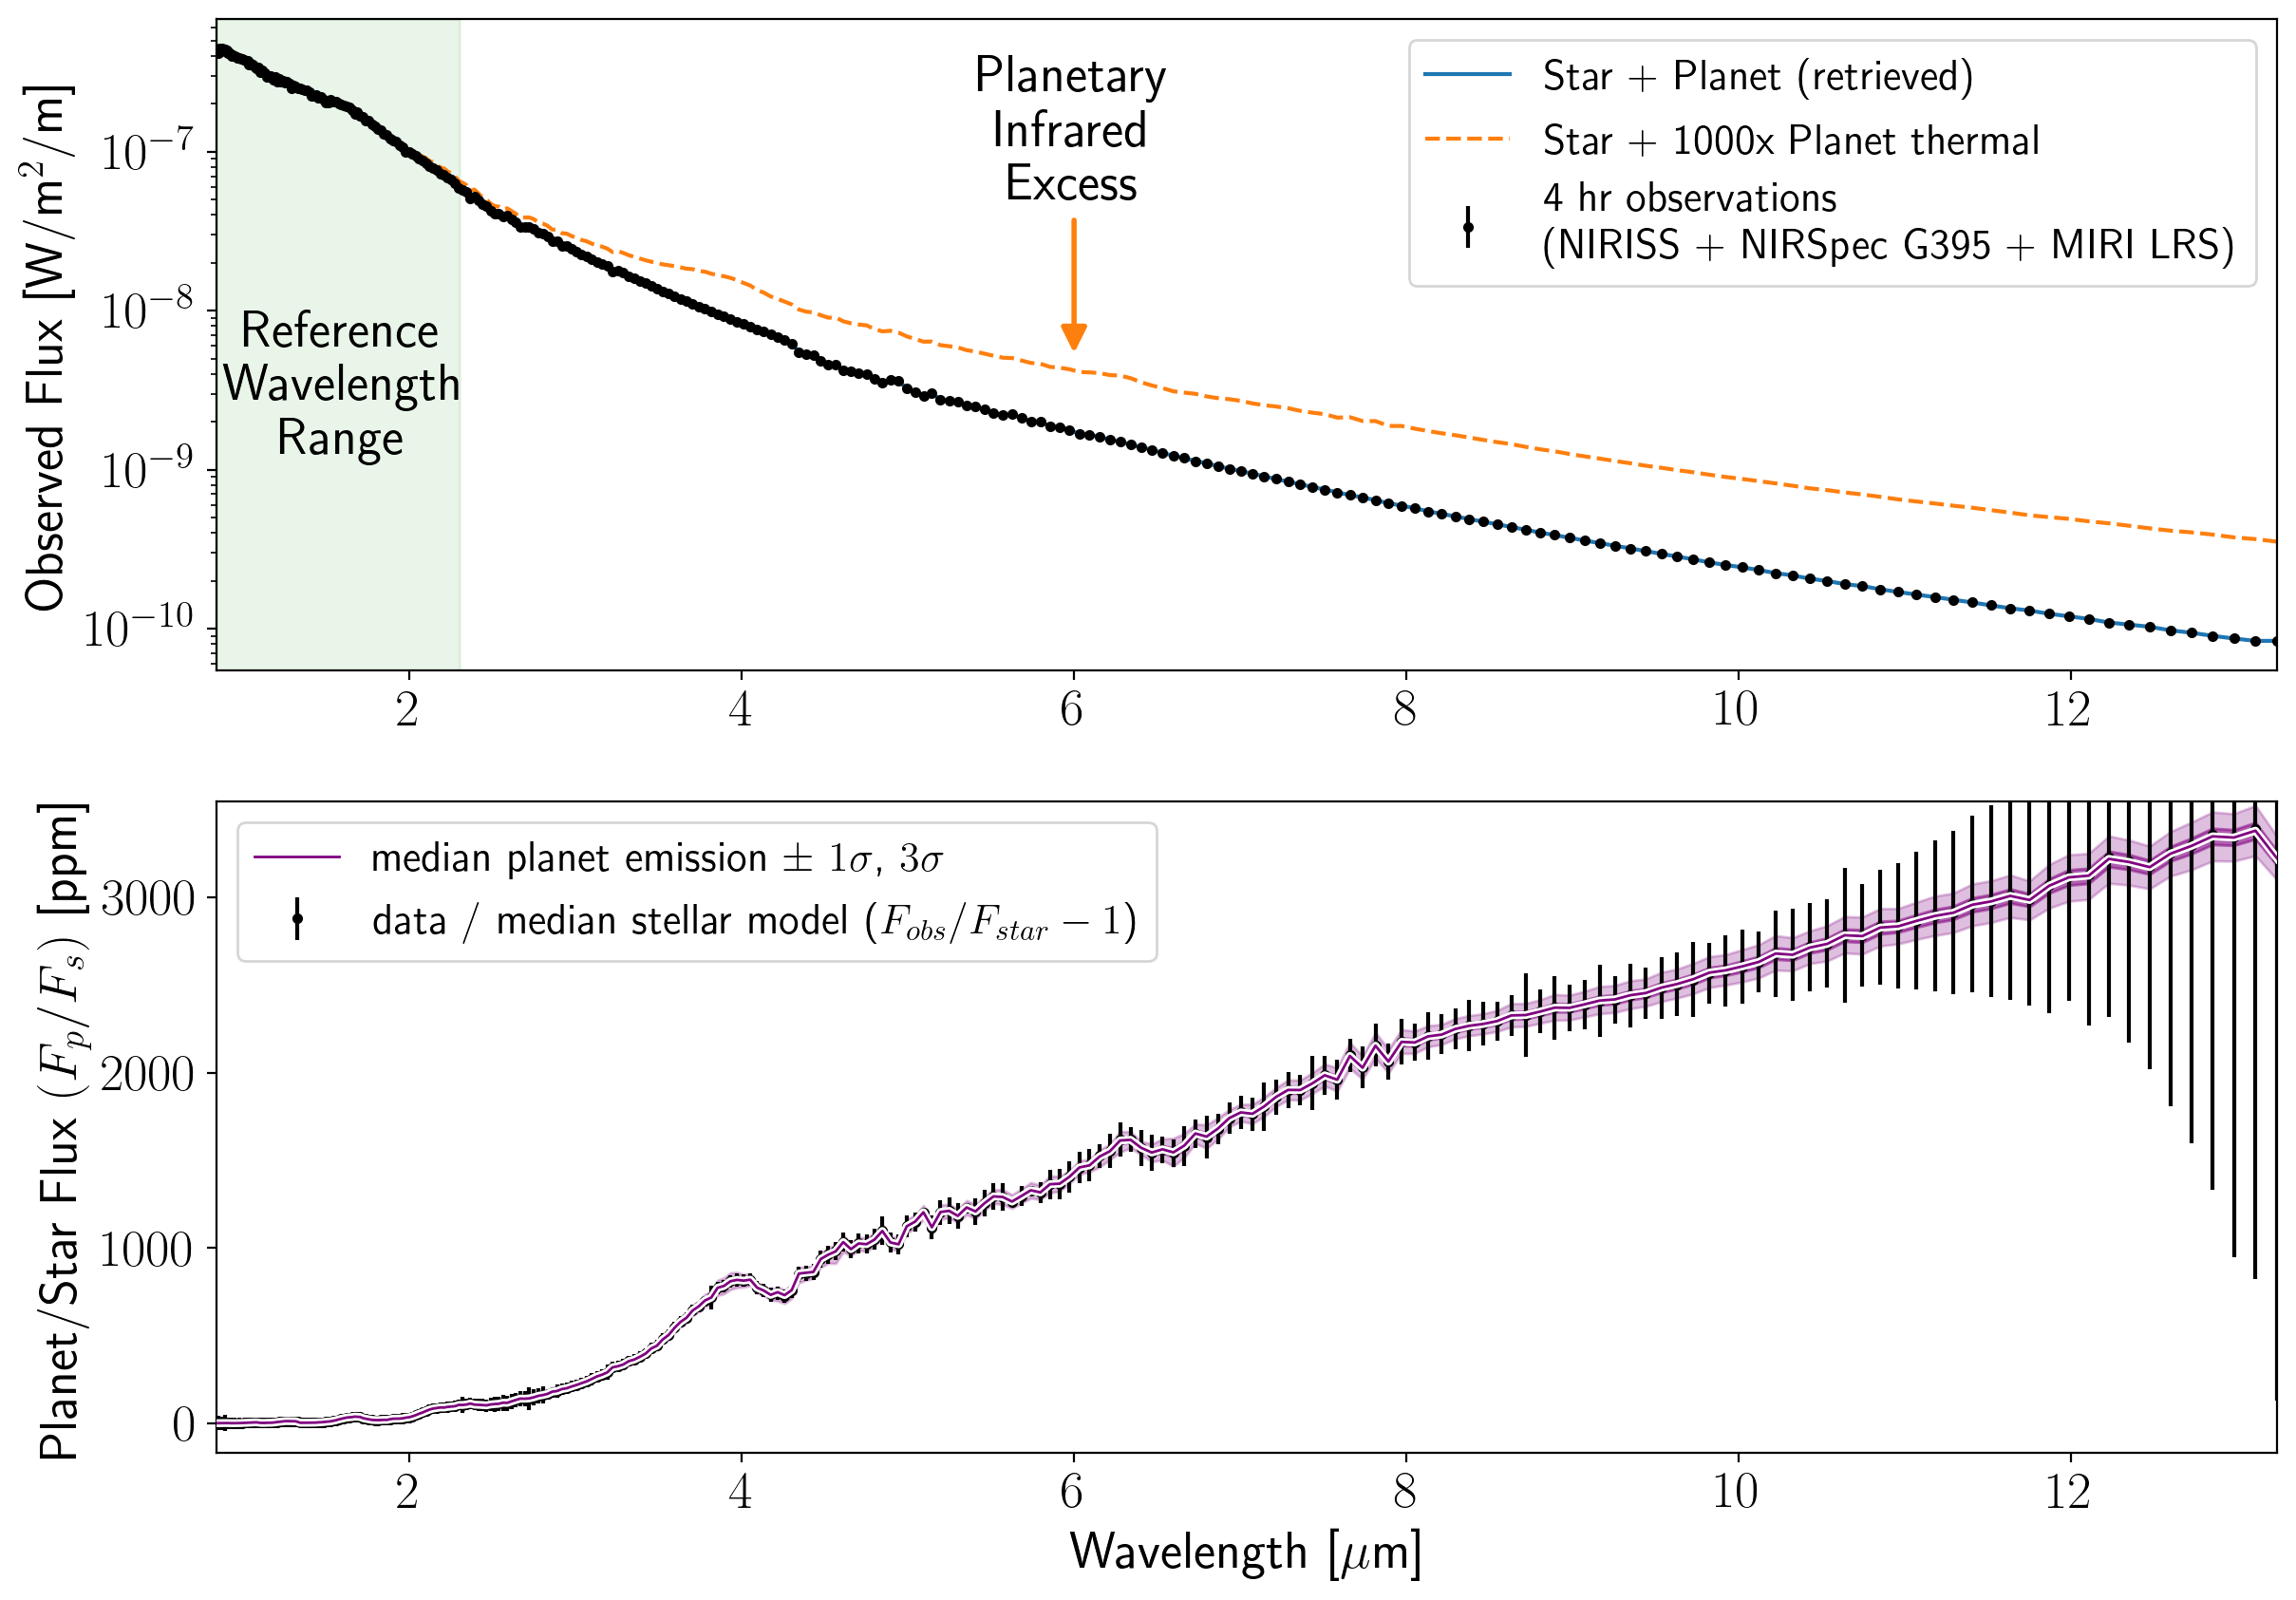

In [45]:
# Plot
fig, axes = plt.subplots(2,1, figsize = (14, 10))

ax= axes[0]
ax2 = axes[1]

ax.set_xlim(wl.min(), wl.max())
ax2.set_xlim(wl.min(), wl.max())
ax2.set_xlabel("Wavelength [$\mu$m]")
ax.set_ylabel("Observed Flux [W/m$^2$/m]")

#ax.plot(wl, y_binned, label = "Star + Planet (truth)", color = "C0")
ax.plot(wl, Fobs_50_1, label = "Star + Planet (retrieved)", color = "C0")
#ax.plot(wl, y_planet, label = "Planet thermal", color = "C3")
ax.errorbar(wl, y_meas, yerr=y_err, fmt = ".k", label = "4 hr observations \n(NIRISS + NIRSpec G395 + MIRI LRS)")
#ax.plot(wl, Fstar_earth + 1000*Fplan_therm_earth, label = "Star + 1000x Planet thermal", color = "C1")
ax.plot(wl, Fstar_50_1 + 1000*Fplan_50_1, label = "Star + 1000x Planet thermal", color = "C1", ls = "--")

ax.set_yscale("log")
ax.legend(fontsize = 16, loc = "upper right")

ax.axvspan(wl.min(), 2.3, color="C2", alpha = 0.1)
ax.text(1.6, 1e-8, "Reference\nWavelength\nRange", ha = "center", va = "top")

ax.text(6.0, 1.3e-7, "Planetary\nInfrared\nExcess", ha = "center", va = "center")
ax.annotate("", xy=(6.0, 5e-9), xytext=(6.0, 4e-8), arrowprops=dict(arrowstyle="-|>", color="C1", lw=2))

ax2.set_ylabel("Planet/Star Flux $(F_p/F_s)$ [ppm]")
#ax2.plot(wl, 1e6*(y_binned/Fstar_earth-1.0), color = "w", lw = 4.0, zorder = 100)
#ax2.plot(wl, 1e6*(y_binned/Fstar_earth-1.0), color = "C3", label = "Planet-to-Star Flux ($F_{pl}/F_{star}$)", zorder = 100)
#ax2.plot(wl, 1e6*(Fobs/Fstar-1.0), color = "w", lw = 4.0, zorder = 100)

# Plot median spectrum
l1 = ax2.plot(wl, 1e6*FpFs_50_1, lw = 3.0, c="w", zorder = 100, alpha = 1.0)
l2 = ax2.plot(wl, 1e6*FpFs_50_1, lw = 1.0, c="purple", zorder = 100, alpha = 1.0, label = "median planet emission $\pm$ $1 \sigma$, $3 \sigma$")
#ax2.plot(wl, 1e6*(Fobs/Fstar-1.0), color = "C3", label = "Retrieved Planet-to-Star Flux ($F_{pl}/F_{star}$)", zorder = 100)

ylim = ax2.get_ylim()
#ax2.errorbar(wl, 1e6*(FpFs_obs_50_1), yerr = 1e6*np.sqrt((y_err/Fstar_50_1)**2 + (FpFs_obs_std)**2), fmt=".C0")#, label = "propagated error from stellar model")
ax2.errorbar(wl, 1e6*(y_meas/Fstar_50_1-1.0), yerr = 1e6*(y_err/Fstar_50_1), fmt=".k", label = "data / median stellar model ($F_{obs} / F_{star} - 1$)")

# Plot envelopes
ax2.fill_between(wl, 1e6*FpFs_l_1, 1e6*FpFs_h_1, color = "purple", alpha = 0.5)
ax2.fill_between(wl, 1e6*FpFs_l_3, 1e6*FpFs_h_3, color = "purple", alpha = 0.25)

ax2.set_ylim(ylim[0], ylim[1])
ax2.legend(fontsize = 16)
#ax2.set_yscale("log")

#fig.savefig("/Users/lustija1/Documents/exoPIE_IRAD/W43b_PIE_retrieval_spectrum_%s.png" %tag, bbox_inches = "tight")


In [75]:
# Get random samples from posterior
Nsamples = 2000

inds = np.random.choice(np.arange(chain.shape[0]), size = Nsamples, replace = False)
theta_samples = chain[inds, :]

# Calculate the TP profile used to generate the data
# Make a dict of the current state
theta_dict = {}
#Unpacking Guillot 2010 TP profile params (3 params)
Tirr = theta_dict.get("Tirr", exopie.THETA_DEFAULTS["Tirr"])
logKir = theta_dict.get("logKir", exopie.THETA_DEFAULTS["logKir"])
logg1 = theta_dict.get("logg1", exopie.THETA_DEFAULTS["logg1"])
Tint = theta_dict.get("Tint", exopie.THETA_DEFAULTS["Tint"])
#unpacking planet params
Rp = theta_dict.get("Rp", exopie.THETA_DEFAULTS["Rp"])  #planet radius (in jupiter)
M = theta_dict.get("M", exopie.THETA_DEFAULTS["M"])     #planet mass (in jupiter)
# Calculate TP profile
logP = np.arange(-6.8,1.5,0.1)+0.1
P = 10.0**logP
g0=6.67384e-11*M*1.898E27/(Rp*71492.*1e3)**2
kv=10.**(logg1+logKir)
kth=10.**logKir
tp=chimera.fm.TP(Tirr, Tint,g0 , kv, kv, kth, 0.5)
T = np.interp(logP,np.log10(tp[1]),tp[0])
Ttrue=0.5*(T[1:]+T[:-1])
Pavg=0.5*(P[1:]+P[:-1])

# Run model at points
Ts = []
for i, t in enumerate(theta_samples):

    # Make a dict of the current state
    theta_dict = dict(zip(exopie.THETA_NAMES, t))

    #Unpacking Guillot 2010 TP profile params (3 params)
    Tirr = theta_dict.get("Tirr", exopie.THETA_DEFAULTS["Tirr"])
    logKir = theta_dict.get("logKir", exopie.THETA_DEFAULTS["logKir"])
    logg1 = theta_dict.get("logg1", exopie.THETA_DEFAULTS["logg1"])
    Tint = theta_dict.get("Tint", exopie.THETA_DEFAULTS["Tint"])

    #unpacking planet params
    Rp = theta_dict.get("Rp", exopie.THETA_DEFAULTS["Rp"])  #planet radius (in jupiter)
    M = theta_dict.get("M", exopie.THETA_DEFAULTS["M"])     #planet mass (in jupiter)

    # Calculate TP profile
    logP = np.arange(-6.8,1.5,0.1)+0.1
    P = 10.0**logP
    g0=6.67384e-11*M*1.898E27/(Rp*71492.*1e3)**2
    kv=10.**(logg1+logKir)
    kth=10.**logKir
    tp=chimera.fm.TP(Tirr, Tint,g0 , kv, kv, kth, 0.5)
    T = np.interp(logP,np.log10(tp[1]),tp[0])
    Tavg=0.5*(T[1:]+T[:-1])
    Pavg=0.5*(P[1:]+P[:-1])
    
    Ts.append(Tavg)
    
Ts = np.array(Ts)

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


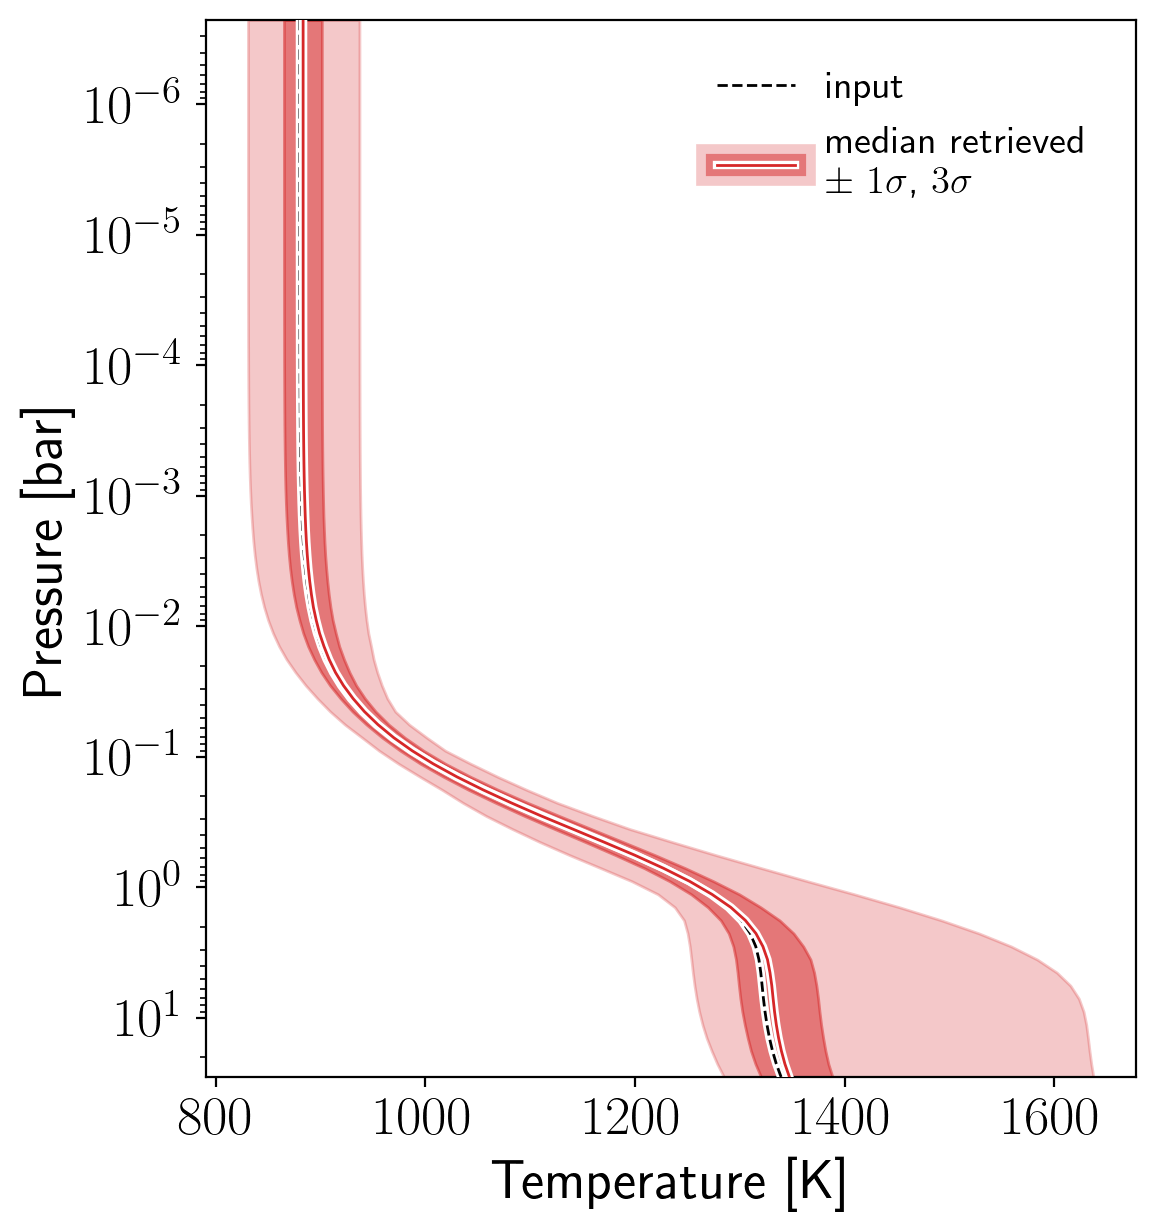

In [76]:
# Specify the upper and lower 1- and 3-sigma confidence intervals for the spectra
s1 = 0.6827 # 1-sigma
s2 = 0.9545 # 2-sigma
s3 = 0.9973 # 3-sigma
q1 = [0.5 - 0.5*s1, 0.5, 0.5 + 0.5*s1] # 1-sigma quantiles
q3 = [0.5 - 0.5*s3, 0.5, 0.5 + 0.5*s3] # 3-sigma quantiles

# Calculate percentile spectra (returns: lower bound, median, upper bound)
T_l_1, T_50_1, T_h_1 = np.percentile(Ts, list(100.0 * np.array(q1)), axis=0) # 1-sigma
T_l_3, T_50_3, T_h_3 = np.percentile(Ts, list(100.0 * np.array(q3)), axis=0) # 3-sigma

color = "C3"

fig, ax = plt.subplots(figsize=(6,7))
ax.set_ylabel("Pressure [bar]")
ax.set_xlabel("Temperature [K]")

lt1, = ax.plot(Ttrue, Pavg, lw = 3.0, c="w", zorder = 100, alpha = 1.0)
lt2, = ax.plot(Ttrue, Pavg, lw = 1.0, c="k", zorder = 100, alpha = 1.0, ls = "dashed")

# Plot median TP
lm1, = ax.plot(T_50_1, Pavg, lw = 3.0, c="w", zorder = 100, alpha = 1.0)
lm2, = ax.plot(T_50_1, Pavg, lw = 1.0, c=color, zorder = 100, alpha = 1.0)

# Plot TP envelopes
ax.fill_betweenx(Pavg, T_l_1, T_h_1, color = color, alpha = 0.5)
ax.fill_betweenx(Pavg, T_l_3, T_h_3, color = color, alpha = 0.25)

# Create fake lines to use in custom legend
p1 = mpl.lines.Line2D([0], [0], color=color, alpha=0.5, linewidth=8)
p2 = mpl.lines.Line2D([0], [0], color=color, alpha=0.25, linewidth=15)

ax.invert_yaxis()
ax.set_yscale("log")
ax.set_ylim(Pavg.max(), Pavg.min())

handles = [(lt1, lt2), (p1, p2, lm1, lm2)]
labels = ["input", "median retrieved \n$\pm$ $1 \sigma$, $3 \sigma$"]

ax.legend(handles, labels, fontsize = 14, borderpad = 0.75, framealpha = 0.0)

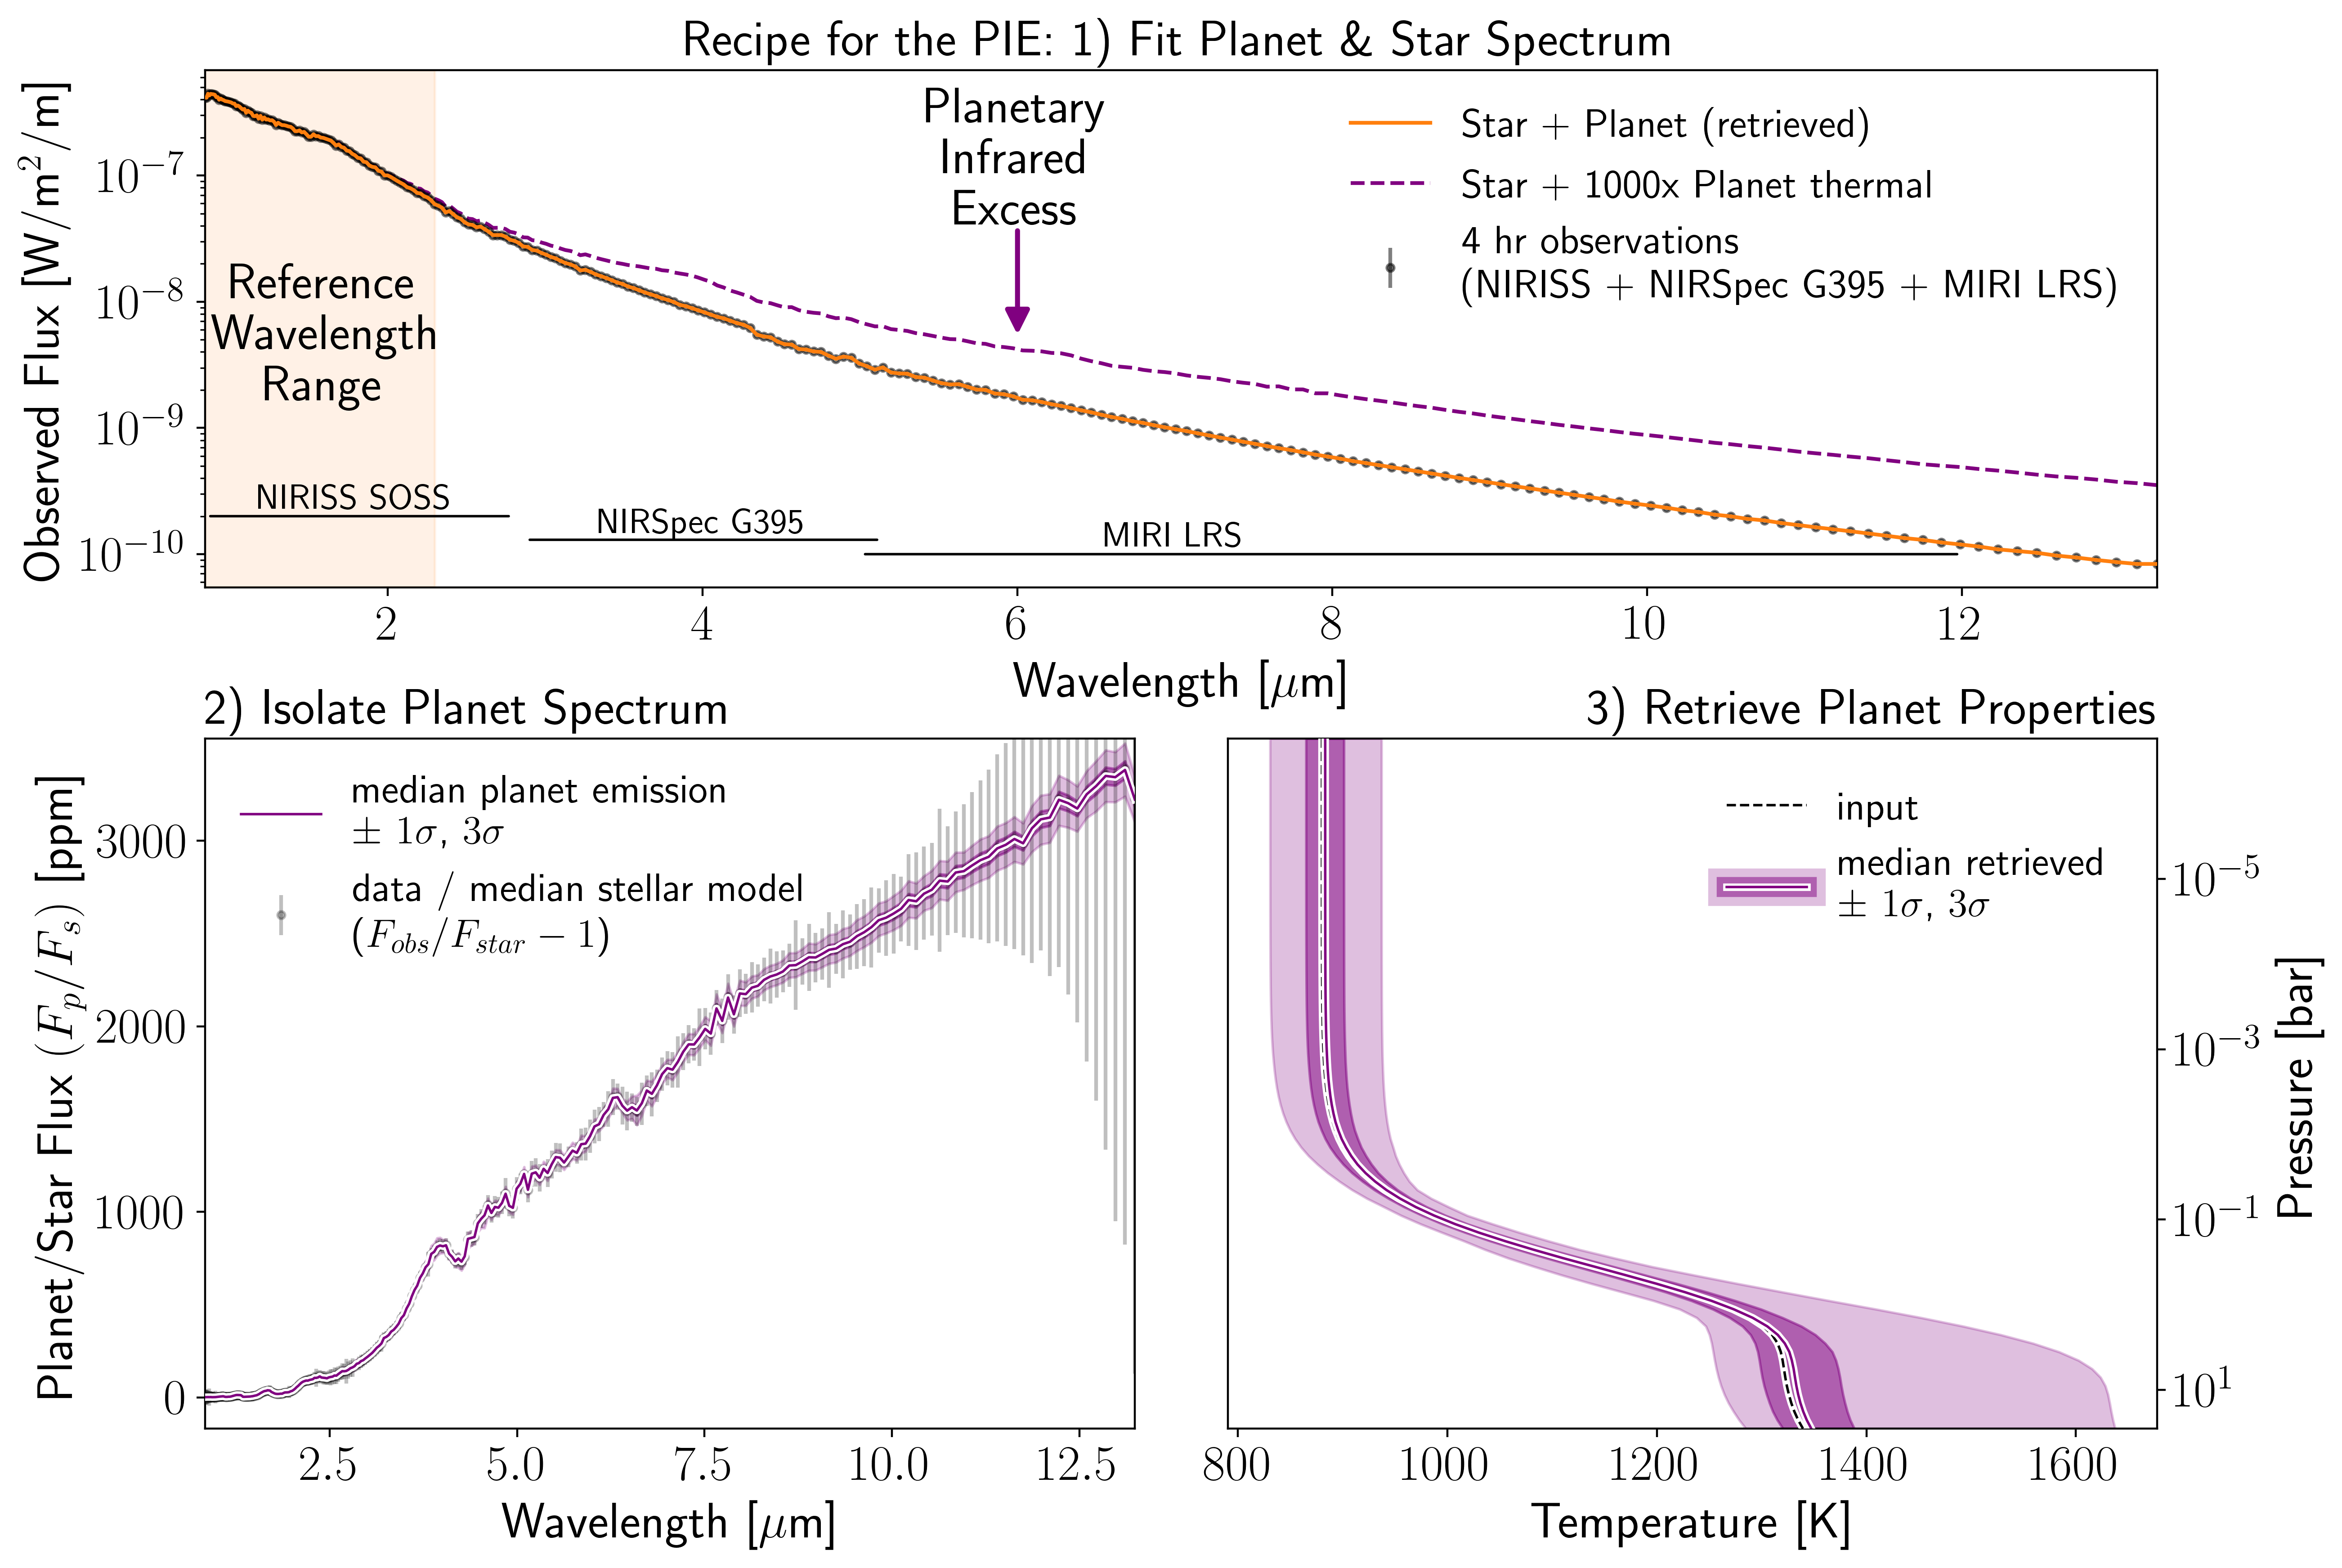

In [132]:
from mpl_toolkits.axes_grid.inset_locator import (inset_axes, InsetPosition,
                                                  mark_inset)

fig = plt.figure(figsize = (14,10), constrained_layout=False)
gs = fig.add_gridspec(2, 2, hspace=0.25, wspace=0.1, height_ratios=(0.75, 1))
ax = fig.add_subplot(gs[0, 0:2])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1])

pcolor = "purple"

ax.set_xlim(wl.min(), wl.max())
ax2.set_xlim(wl.min(), wl.max())
ax.set_xlabel("Wavelength [$\mu$m]")
ax2.set_xlabel("Wavelength [$\mu$m]")
ax.set_ylabel("Observed Flux [W/m$^2$/m]")

#ax.plot(wl, y_binned, label = "Star + Planet (truth)", color = "C0")
ax.plot(wl, Fobs_50_1, label = "Star + Planet (retrieved)", color = "C1", zorder=100)
#ax.plot(wl, y_planet, label = "Planet thermal", color = "C3")
ax.errorbar(wl, y_meas, yerr=y_err, fmt = ".k", alpha = 0.5, label = "4 hr observations \n(NIRISS + NIRSpec G395 + MIRI LRS)")
#ax.plot(wl, Fstar_earth + 1000*Fplan_therm_earth, label = "Star + 1000x Planet thermal", color = "C1")
ax.plot(wl, Fstar_50_1 + 1000*Fplan_50_1, label = "Star + 1000x Planet thermal", color = pcolor, ls = "--")

ax.set_yscale("log")
ax.legend(fontsize = 16, loc = "upper right", framealpha=0.0)

ax.axvspan(wl.min(), 2.3, color="C1", alpha = 0.1)
ax.text(1.6,2e-8, "Reference\nWavelength\nRange", ha = "center", va = "top")

ax.text(6.0, 1.3e-7, "Planetary\nInfrared\nExcess", ha = "center", va = "center")
ax.annotate("", xy=(6.0, 5e-9), xytext=(6.0, 4e-8), arrowprops=dict(arrowstyle="-|>", color=pcolor, lw=2))

# NIRISS SOSS 0.6–2.8
cx = "k"
ax.annotate("", xy=(wl.min(), 2e-10), xytext=(2.8, 2e-10), arrowprops=dict(arrowstyle="-", lw=1))
ax.text(1.8, 2e-10, "NIRISS SOSS", color = cx, fontsize=14, ha="center", va="bottom")

# NIRSPEC G395 2.87–5.14
ax.annotate("", xy=(2.87, 1.3e-10), xytext=(5.14, 1.3e-10), arrowprops=dict(arrowstyle="-", lw=1))
ax.text(4, 1.3e-10, "NIRSpec G395", color = cx, fontsize=14, ha="center", va="bottom")

# MIRI LRS 5-12
ax.annotate("", xy=(5, 1e-10), xytext=(12, 1e-10), arrowprops=dict(arrowstyle="-", lw=1))
ax.text(7, 1e-10, "MIRI LRS", color = cx, fontsize=14, ha="center", va="bottom")

ax2.set_ylabel("Planet/Star Flux $(F_p/F_s)$ [ppm]")
#ax2.set_yscale("log")
#ax2.plot(wl, 1e6*(y_binned/Fstar_earth-1.0), color = "w", lw = 4.0, zorder = 100)
#ax2.plot(wl, 1e6*(y_binned/Fstar_earth-1.0), color = "C3", label = "Planet-to-Star Flux ($F_{pl}/F_{star}$)", zorder = 100)
#ax2.plot(wl, 1e6*(Fobs/Fstar-1.0), color = "w", lw = 4.0, zorder = 100)

# Plot median spectrum
l1 = ax2.plot(wl, 1e6*FpFs_50_1, lw = 3.0, c="w", zorder = 100, alpha = 1.0)
l2 = ax2.plot(wl, 1e6*FpFs_50_1, lw = 1.0, c=pcolor, zorder = 100, alpha = 1.0, label = "median planet emission \n$\pm$ $1 \sigma$, $3 \sigma$")
#ax2.plot(wl, 1e6*(Fobs/Fstar-1.0), color = "C3", label = "Retrieved Planet-to-Star Flux ($F_{pl}/F_{star}$)", zorder = 100)

ylim = ax2.get_ylim()
#ax2.errorbar(wl, 1e6*(FpFs_obs_50_1), yerr = 1e6*np.sqrt((y_err/Fstar_50_1)**2 + (FpFs_obs_std)**2), fmt=".C0")#, label = "propagated error from stellar model")
ax2.errorbar(wl, 1e6*(y_meas/Fstar_50_1-1.0), yerr = 1e6*(y_err/Fstar_50_1), fmt=".k", 
             label = "data / median stellar model \n($F_{obs} / F_{star} - 1$)", 
             alpha=0.25)

# Plot envelopes
ax2.fill_between(wl, 1e6*FpFs_l_1, 1e6*FpFs_h_1, color = pcolor, alpha = 0.5)
ax2.fill_between(wl, 1e6*FpFs_l_3, 1e6*FpFs_h_3, color = pcolor, alpha = 0.25)

ax2.set_ylim(ylim[0], ylim[1])
ax2.legend(fontsize = 16, loc="upper left", framealpha=0.0)

#mark_inset(ax, ax2, loc1=3, loc2=4, fc="none", ec='0.5');


ax3.yaxis.set_label_position("right")
ax3.yaxis.tick_right()
ax3.set_ylabel("Pressure [bar]")
ax3.set_xlabel("Temperature [K]")

lt1, = ax3.plot(Ttrue, Pavg, lw = 3.0, c="w", zorder = 100, alpha = 1.0)
lt2, = ax3.plot(Ttrue, Pavg, lw = 1.0, c="k", zorder = 100, alpha = 1.0, ls = "dashed")

# Plot median TP
lm1, = ax3.plot(T_50_1, Pavg, lw = 3.0, c="w", zorder = 100, alpha = 1.0)
lm2, = ax3.plot(T_50_1, Pavg, lw = 1.0, c=pcolor, zorder = 100, alpha = 1.0)

# Plot TP envelopes
ax3.fill_betweenx(Pavg, T_l_1, T_h_1, color = pcolor, alpha = 0.5)
ax3.fill_betweenx(Pavg, T_l_3, T_h_3, color = pcolor, alpha = 0.25)

# Create fake lines to use in custom legend
p1 = mpl.lines.Line2D([0], [0], color=pcolor, alpha=0.5, linewidth=8)
p2 = mpl.lines.Line2D([0], [0], color=pcolor, alpha=0.25, linewidth=15)

ax3.invert_yaxis()
ax3.set_yscale("log")
ax3.set_ylim(Pavg.max(), Pavg.min())

handles = [(lt1, lt2), (p1, p2, lm1, lm2)]
labels = ["input", "median retrieved \n$\pm$ $1 \sigma$, $3 \sigma$"]

ax3.legend(handles, labels, fontsize = 16, borderpad = 0.75, framealpha = 0.0, loc = 0)

ax.set_title("Recipe for the PIE: 1) Fit Planet \& Star Spectrum", fontweight="bold", fontsize=mpl.rcParams['axes.labelsize'])
ax2.set_title("2) Isolate Planet Spectrum", loc="left", fontweight="bold", fontsize=mpl.rcParams['axes.labelsize'])
ax3.set_title("3) Retrieve Planet Properties", loc="right", fontweight="bold", fontsize=mpl.rcParams['axes.labelsize'])

fig.savefig("/Users/lustija1/Documents/Proposals/XRP2021_PIE/exopie_wasp43b_figure.png", bbox_inches="tight")